In [1]:
import numpy as np
import xarray as xr
import seaborn as sns
from scipy import linalg as LA
import matplotlib.pyplot as plt


def linalg_lstq(src, var, order=1):
    
    XX, YY = np.meshgrid(src.T_ma, src.offset)
    ZZ     = src[var].values
    mask   = src.mask.values
    
    # Check that an appropriate order was passed to the function
    if order not in [1]:
        raise ValueError('Invalid Order. Must be of order 1')
        
    # Compute the design Matrix (A)
    if order == 1: 
        # Linear Surface
        A_fit  = np.hstack([XX[~mask][:,None]**[0,1],
                            YY[~mask][:,None]**[1] ])
        A_full = np.hstack([XX.flatten()[:,None]**[0,1],
                            YY.flatten()[:,None]**[1] ])
    
    # Compute a vector x such that the 2-norm |b - A x| is minimized.
    C, res, rnk, s = LA.lstsq(A_fit, ZZ[~mask][:,None])
    
        
    
    # Predict values
    Z_hat = np.dot(A_full, C).reshape(ZZ.shape)

    return Z_hat, C



In [2]:
src = xr.open_dataset('../crmpt12_dx50_nz15_SS_fields_@3ka.nc')
src = src.squeeze()

In [3]:
# Modeled grid of parameter vals
T_mgrid, B_mgrid = np.meshgrid(src.T_ma, src.offset)

In [4]:
diff_offset = src.relative_volume.isel(offset=-1) - src.relative_volume.isel(offset=0)

print(f'{float(diff_offset.mean()):.3} +/- {float(diff_offset.std()):.3}')

0.605 +/- 0.00204


In [5]:
diff_Tma = src.relative_volume.isel(T_ma=-1) - src.relative_volume.isel(T_ma=0)

print(f'{float(diff_Tma.mean()):.3} +/- {float(diff_Tma.std()):.3}')

-0.0394 +/- 0.00786


## Relaitve Volume (V')

In [6]:
V_prime_hat, V_prime_C = linalg_lstq(src, 'relative_volume')
V_prime_res = (src.relative_volume - V_prime_hat).values * 100 

Text(0.5, 0, 'Residuals [\\%]')

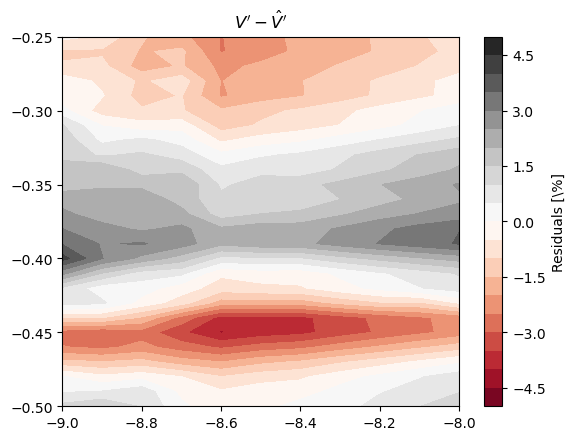

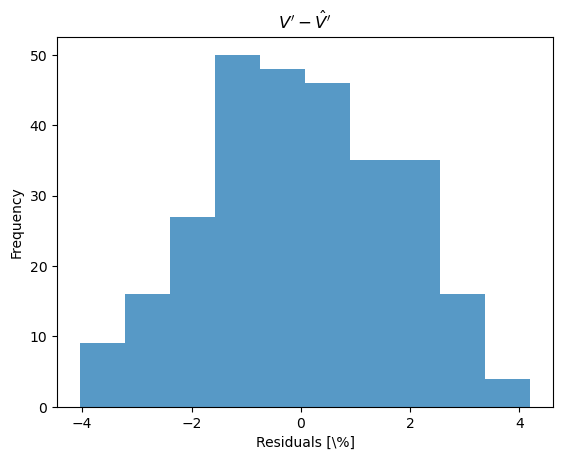

In [11]:
# plot contour of resiuals 
fig, ax = plt.subplots()

im = ax.contourf(T_mgrid, B_mgrid, V_prime_res, 
                 cmap='RdGy', levels = np.linspace(-5,5,21))


ax.set_title("$V' - \hat V'$")
fig.colorbar(im, ax=ax, label='Residuals [\%]')

# plot histogram of residuals 

fig, ax = plt.subplots()

ax.set_title("$V' - \hat V'$")
ax.hist(V_prime_res.flatten(), alpha=0.75)

ax.set_ylabel('Frequency')
ax.set_xlabel('Residuals [\%]')

In [12]:
# print 
print(f"dV'/dT = {V_prime_C[1,0]:0.3f}")
print(f"dV'/db = {V_prime_C[2,0]:0.3f}")
print(f"ratio  = {V_prime_C[2,0]/V_prime_C[1,0]:3.2f}")


dV'/dT = -0.039
dV'/db = 2.501
ratio  = -63.68


## Percent Temperate 

In [14]:
PT_hat, PT_C = linalg_lstq(src, 'percent_temperate')
PT_res = (src.percent_temperate - PT_hat).values

Text(0.5, 0, 'Residuals [\\%]')

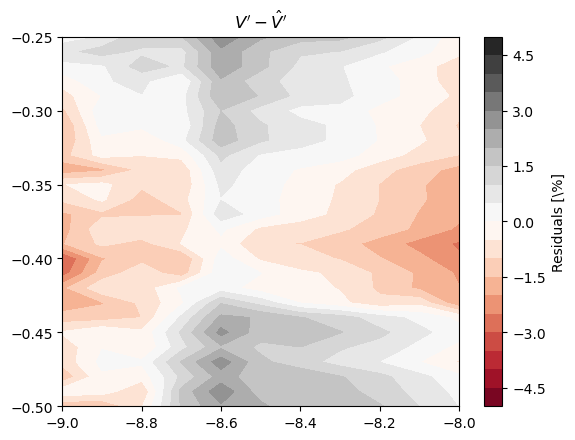

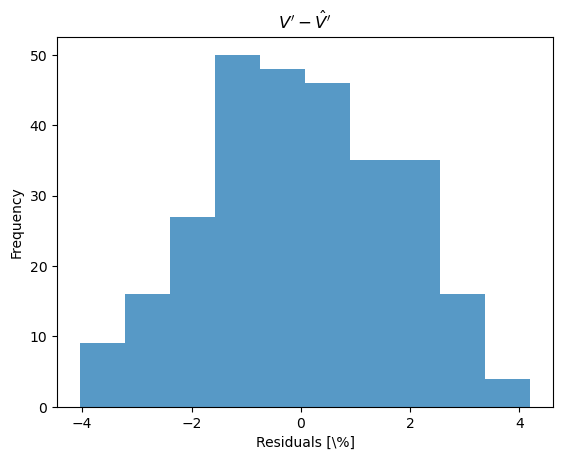

In [15]:
# plot contour of resiuals 
fig, ax = plt.subplots()

im = ax.contourf(T_mgrid, B_mgrid, PT_res, 
                 cmap='RdGy', levels = np.linspace(-5,5,21))


ax.set_title("$V' - \hat V'$")
fig.colorbar(im, ax=ax, label='Residuals [\%]')

# plot histogram of residuals 

fig, ax = plt.subplots()

ax.set_title("$V' - \hat V'$")
ax.hist(V_prime_res.flatten(), alpha=0.75)

ax.set_ylabel('Frequency')
ax.set_xlabel('Residuals [\%]')

In [16]:
# print 
print(f"dPT/dT = {PT_C[1,0]:0.3f}")
print(f"dPT/db = {PT_C[2,0]:0.3f}")
print(f"ratio  = {PT_C[2,0]/PT_C[1,0]:3.2f}")


dPT/dT = 5.889
dPT/db = 43.063
ratio  = 7.31


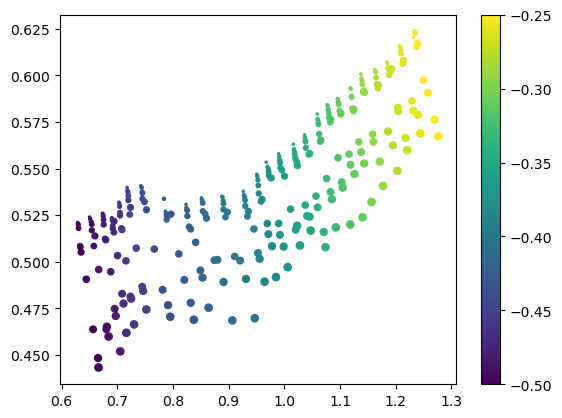

In [17]:
im = plt.scatter(src.relative_volume, 
                 src.percent_temperate/100, 
                 c=B_mgrid,
                 s =25 * (np.abs(T_mgrid) - 7.9))


plt.colorbar(im)

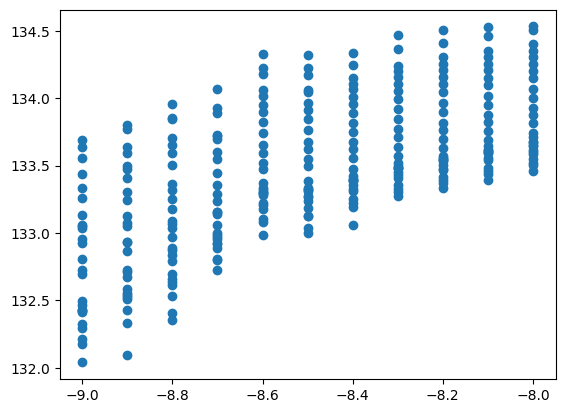

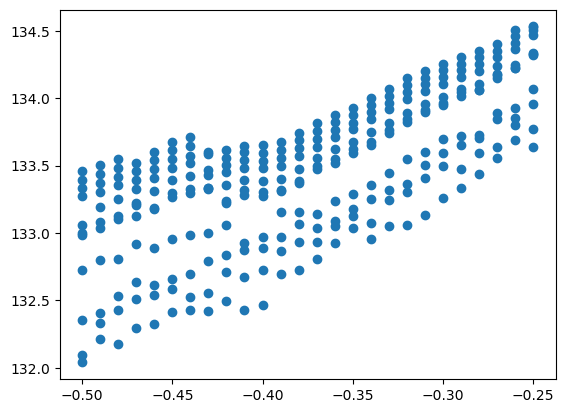

In [18]:
im = plt.scatter(T_mgrid, src.mean_enthalpy)

plt.subplots()
im = plt.scatter(B_mgrid, src.mean_enthalpy)

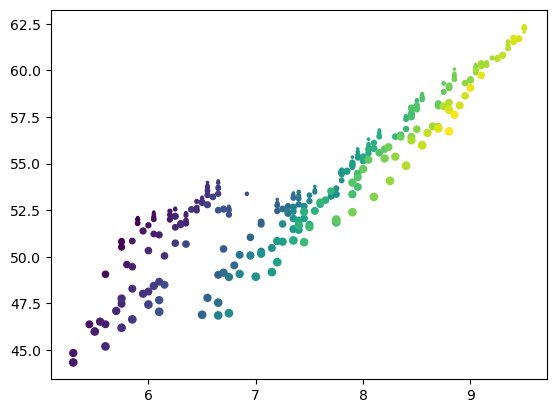

In [19]:
plt.scatter(src.temp_length, 
            src.percent_temperate, 
            c=src.relative_volume, 
            s=25 * (np.abs(T_mgrid) - 7.9))

In [20]:
import sklearn

In [21]:
100 * (src.mean_enthalpy.max() - src.mean_enthalpy.min()) / (src.mean_enthalpy.max() + src.mean_enthalpy.min())

<xarray.DataArray 'mean_enthalpy' ()>
array(0.93462296)
Coordinates:
    t        float64 2.991e+03

In [22]:
100 * (src.percent_temperate.max() - src.percent_temperate.min()) / ( src.percent_temperate.min() + src.percent_temperate.max())

<xarray.DataArray 'percent_temperate' ()>
array(16.90811875)
Coordinates:
    t        float64 2.991e+03

In [23]:
src.percent_temperate.min()

<xarray.DataArray 'percent_temperate' ()>
array(44.32082531)
Coordinates:
    t        float64 2.991e+03